# Preprocessing

## Featurizing

In [1]:
import mdtraj as md
import numpy as np
import datetime
import tensorflow as tf
import nglview as nv


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


%cd /home/jovyan/ASMSA/mydev

import os, sys

repo_dir = os.getcwd()   
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)

# 3. Fai l’import “pulito”
from utils import split_dataset, callbacks, plot_latent_space, process_trajectory
from vae import build_asmsa_beta_vae

nn_model = 'vae'
latent_dim = 2

2025-08-07 12:32:46.594709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-07 12:32:46.607333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-07 12:32:46.611213: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-07 12:32:46.620577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-07 12:32:47.228638: W tensorflow/compiler/tf2

[Errno 2] No such file or directory: '/home/jovyan/ASMSA/mydev'
/home/tedeschg/prj/ASMSA/mydev


In [2]:
tr = "trpcage_ds_nH.xtc"
conf = "trpcage_npt400_nH.pdb"

traj = md.load_xtc(tr, top=conf)
backbone_atoms = traj.topology.select('backbone')
traj.superpose(traj, 0, atom_indices=backbone_atoms)

<mdtraj.Trajectory with 50001 frames, 144 atoms, 20 residues, and unitcells at 0x76b8eb2bf850>

In [3]:
view = nv.show_mdtraj(traj)

view.add_representation('line', selection='protein')
view

NGLWidget(max_frame=50000)

In [4]:
ca_indices, n_ca, bb_indices, n_bb, features_normalized, scaler, coords = process_trajectory(tr, conf)
features_normalized.shape

(50001, 558)

## NN preprocessing

In [5]:
# Uso:
ds_train, ds_val, ds_test, ds_all = split_dataset(features_normalized, train_size=70, val_size=15, batch_size=64, seed=42)

I0000 00:00:1754562771.065962  146838 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754562771.084048  146838 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754562771.084202  146838 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754562771.084965  146838 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Dataset Statistics:
  Train: 35000 samples, 546 batches
  Val:   7500 samples, 118 batches
  Test:  7501 samples, 118 batches
  Batch size: 64


# VAE

In [6]:
'''
Batch Norm, nel caso, va prima della layer activation)
'''

'\nBatch Norm, nel caso, va prima della layer activation)\n'

In [7]:
log_dir = "logs/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

cb = callbacks(log_dir, latent_dim, monitor="val_loss")

learning_rate = 1e-4

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=learning_rate,
    weight_decay=1e-5, 
    beta_1=0.9,
    beta_2=0.999
)

# Creazione modello con beta migliorato
beta_vae, encoder, decoder = build_asmsa_beta_vae(
    n_features=features_normalized.shape[1], 
    latent_dim=latent_dim,
    beta=0.001 
)

# Compilazione
beta_vae.compile(optimizer=optimizer)

In [8]:
beta_vae.fit(ds_train, epochs=500, validation_data=ds_val, callbacks=cb)

Epoch 1/500


I0000 00:00:1754562776.227148  146895 service.cc:146] XLA service 0x76b7a801c1d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754562776.227173  146895 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-07 12:32:56.308176: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-07 12:32:56.871577: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 45/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 2.1111e-04 - loss: 0.0827 - reconstruction_loss: 0.0825

I0000 00:00:1754562779.154833  146895 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


527/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 6.9007e-04 - loss: 0.0770 - reconstruction_loss: 0.0763
Epoch 1: val_loss improved from inf to 0.06212, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - kl_loss: 7.0782e-04 - loss: 0.0767 - reconstruction_loss: 0.0760 - val_kl_loss: 0.0014 - val_loss: 0.0621 - val_reconstruction_loss: 0.0607 - learning_rate: 1.0000e-04
Epoch 2/500
  1/546 ━━━━━━━━━━━━━━━━━━━━ 55s 102ms/step - kl_loss: 0.0015 - loss: 0.0603 - reconstruction_loss: 0.0588

/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


545/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0012 - loss: 0.0614 - reconstruction_loss: 0.0602
Epoch 2: val_loss improved from 0.06212 to 0.06002, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 0.0012 - loss: 0.0614 - reconstruction_loss: 0.0602 - val_kl_loss: 0.0011 - val_loss: 0.0600 - val_reconstruction_loss: 0.0589 - learning_rate: 1.0000e-04
Epoch 3/500
524/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0012 - loss: 0.0597 - reconstruction_loss: 0.0585
Epoch 3: val_loss improved from 0.06002 to 0.05924, saving model to ae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 0.0012 - loss: 0.0597 - reconstruction_loss: 0.0585 - val_kl_loss: 0.0013 - val_loss: 0.0592 - val_reconstruction_loss: 0.0580 - learning_rate: 1.0000e-04
Epoch 4/500
532/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.0013 - loss: 0.0591 - reconstruction_loss: 0.0578
Epoch 4: val_loss improved from 0.05924 to 0.05852, saving model to ae_2d.keras
546/546 ━━

tensorboard --logdir logs/autoencoder --host localhost --port 6006

# Decode and visualize

In [9]:

from tensorflow.keras.models import load_model

autoencoder = load_model(f'best_beta_vae_2d.keras')
encoder = autoencoder.get_layer("encoder")
decoder = autoencoder.get_layer("decoder")


ValueError: File not found: filepath=best_beta_vae_2d.keras. Please ensure the file is an accessible `.keras` zip file.

In [10]:
for batch_x, _ in ds_test.take(1):
    sample_x = batch_x[30]  
    break
    
sample_x_batch = tf.expand_dims(sample_x, axis=0)
test = encoder.predict(sample_x_batch)

test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


[array([[-0.19380446, -2.1916335 ]], dtype=float32),
 array([[-0.08560348, -2.37165   ]], dtype=float32),
 array([[ 0.82245964, -2.169121  ]], dtype=float32)]

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step


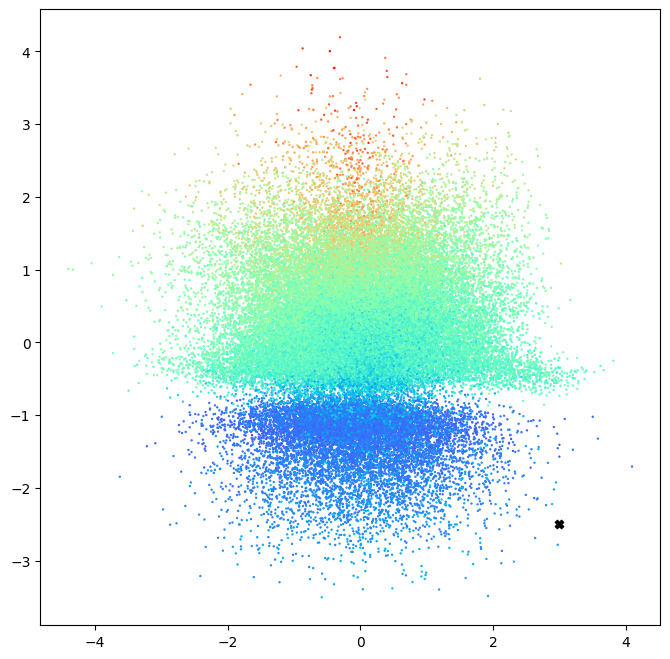

In [48]:
target = np.array([3,-2.5]).reshape(1, latent_dim)
emb, sample = plot_latent_space(latent_dim, encoder, ds_all, conf, tr, target, bb_indices, model=nn_model, exact=False)

In [49]:
rms_ref = md.load_pdb(conf)
rms_ref_bb  = rms_ref.atom_slice(bb_indices)
rms_ref_ca  = rms_ref.atom_slice(ca_indices)
rms_tr = md.load_xtc(tr, top=rms_ref)
rmsd = md.rmsd(rms_tr, rms_ref)

In [50]:
p_indices = traj.topology.select("protein")
n_p = len(p_indices)

In [51]:
s = decoder.predict(sample)
s_orig = scaler.inverse_transform(s)

coords_flat = s_orig[0, :coords.shape[1]]                    
coords_p = coords_flat.reshape((n_p, 3))
mask_bb = np.isin(p_indices, bb_indices)
coords_bb = coords_p[mask_bb] 
coords_ca = coords_bb[1::4] 

new_traj = md.Trajectory(
    xyz=np.array([coords_bb]),     
    topology=rms_ref_bb.topology     
)


new_traj.save_pdb("vae_reconstructed.pdb")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [52]:
view = nv.show_file('vae_reconstructed.pdb')
view.clear_representations()
view.add_line() 
#view.add_cartoon()
view.center()
view

NGLWidget()

In [28]:
mse = np.mean((s[0] - sample_x.numpy())**2)
print("MSE ricostruzione:", mse)

MSE ricostruzione: 0.010586834


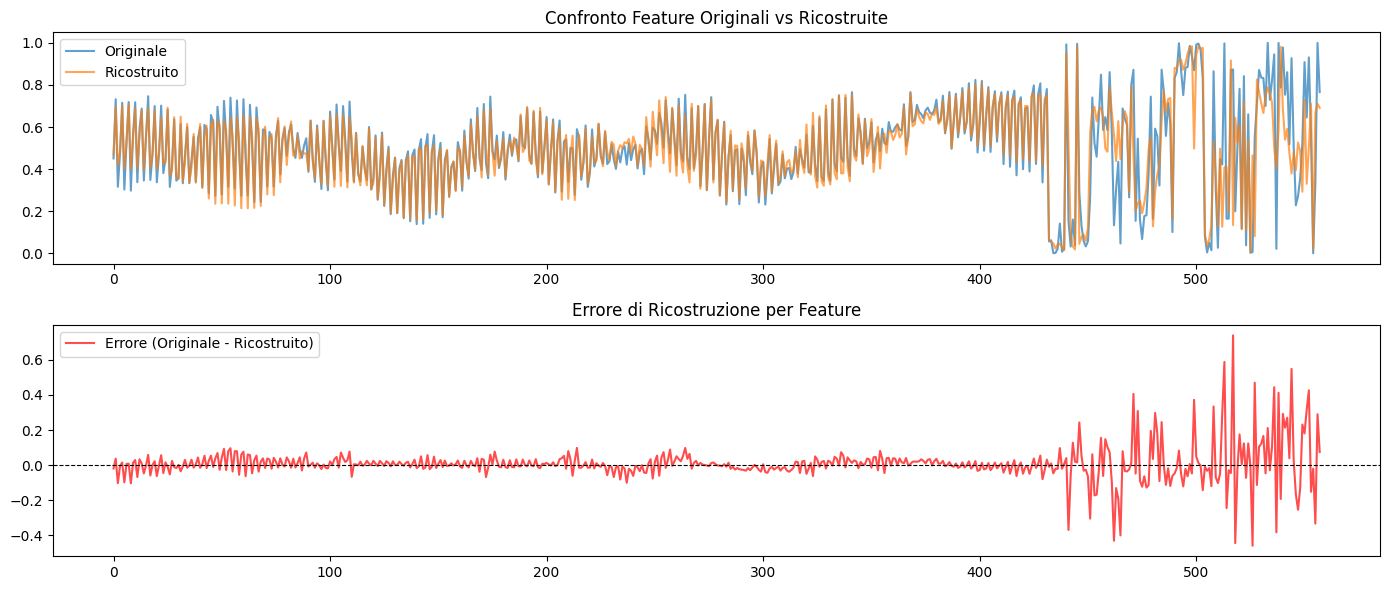

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Serie originali e ricostruite
orig = sample_x.numpy()
recon = s[0]

# Calcolo errore per feature
error = orig - recon

plt.figure(figsize=(14, 6))

# 1️⃣ Confronto original vs ricostruito
plt.subplot(2, 1, 1)
plt.plot(orig, label="Originale", alpha=0.7)
plt.plot(recon, label="Ricostruito", alpha=0.7)
plt.title("Confronto Feature Originali vs Ricostruite")
plt.legend()

# 2️⃣ Errore per feature
plt.subplot(2, 1, 2)
plt.plot(error, label="Errore (Originale - Ricostruito)", color="red", alpha=0.7)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Errore di Ricostruzione per Feature")
plt.legend()

plt.tight_layout()
plt.show()
